In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam

import os
import sys
import time
from tqdm import tqdm, trange
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms
from torchvision import models
from matplotlib import pyplot as plt
from PIL import Image

In [2]:
from net import Net

In [3]:
from utils import StyleLoader, gram_matrix

In [4]:
class StyleLoader():
    def __init__(self, style_folder, style_size, cuda=True):
        self.folder = style_folder
        self.style_size = style_size
        self.files = os.listdir(style_folder)
        self.cuda = cuda
    
    def get(self, i):
        idx = i%len(self.files)
        filepath = os.path.join(self.folder, self.files[idx])
        style = tensor_load_rgbimage(filepath, self.style_size)    
        style = style.unsqueeze(0)
        style = preprocess_batch(style)
        if self.cuda:
            style = style.cuda()
        style_v = Variable(style, requires_grad=False)
        return style_v

    def size(self):
        return len(self.files)

In [5]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram

In [4]:
class Vgg16(torch.nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        self.conv1_1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, X):
        h = F.relu(self.conv1_1(X))
        h = F.relu(self.conv1_2(h))
        relu1_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv2_1(h))
        h = F.relu(self.conv2_2(h))
        relu2_2 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv3_1(h))
        h = F.relu(self.conv3_2(h))
        h = F.relu(self.conv3_3(h))
        relu3_3 = h
        h = F.max_pool2d(h, kernel_size=2, stride=2)

        h = F.relu(self.conv4_1(h))
        h = F.relu(self.conv4_2(h))
        h = F.relu(self.conv4_3(h))
        relu4_3 = h

        return [relu1_2, relu2_2, relu3_3, relu4_3]

In [7]:
class Net(nn.Module):
    def __init__(self, input_nc=3, output_nc=3, ngf=64, norm_layer=nn.InstanceNorm2d, n_blocks=6, gpu_ids=[]):
        super(Net, self).__init__()
        self.gpu_ids = gpu_ids
        self.gram = GramMatrix()

        block = Bottleneck
        upblock = UpBottleneck
        expansion = 4

        model1 = []
        model1 += [ConvLayer(input_nc, 64, kernel_size=7, stride=1),
                            norm_layer(64),
                            nn.ReLU(inplace=True),
                            block(64, 32, 2, 1, norm_layer),
                            block(32*expansion, ngf, 2, 1, norm_layer)]
        self.model1 = nn.Sequential(*model1)

        model = []
        self.ins = Inspiration(ngf*expansion)
        model += [self.model1]
        model += [self.ins]    

        for i in range(n_blocks):
            model += [block(ngf*expansion, ngf, 1, None, norm_layer)]
        
        model += [upblock(ngf*expansion, 32, 2, norm_layer),
                            upblock(32*expansion, 16, 2, norm_layer),
                            norm_layer(16*expansion),
                            nn.ReLU(inplace=True),
                            ConvLayer(16*expansion, output_nc, kernel_size=7, stride=1)]

        self.model = nn.Sequential(*model)

    def setTarget(self, Xs):
        F = self.model1(Xs)
        G = self.gram(F)
        self.ins.setTarget(G)

    def forward(self, input):
        return self.model(input)

In [5]:
def imshow(inp, title=None, plt_ax=None, default=False):
    if plt_ax is None:
        plt_ax = plt.gca()
    if title is None and type(inp) is tuple:
        inp, title = inp
    if type(inp) is tuple:
        inp = inp[0]
    if type(inp) is Image.Image:
        inp = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])(inp)
    if type(inp) is torch.Tensor and inp.is_cuda:
        inp = inp.cpu()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)
    
def grid_show(data, max_images=9, random=False, cols=3):
    imcount = min(len(data), max_images) if max_images > 0 else len(data)
    rows = int(np.ceil(imcount / cols))
    fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(15, rows * 5), sharey=True, sharex=True)
    axs = axs.flatten()
    idxs = range(imcount)
    if random:
        idxs = np.random.choice(len(data), size=imcount)
    for ax, i in enumerate(idxs):
        item = data[i]
        if hasattr(data, 'classes') and type(item) is tuple and len(item) == 2 and type(item[1]) is int:
            item = item[0], data.classes[item[1]]
        imshow(item, plt_ax=axs[ax])

In [7]:
!wget http://images.cocodataset.org/zips/val2014.zip

--2023-01-22 22:14:00--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.1.155, 54.231.164.73, 52.216.41.209, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.1.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip’

val2014.zip         100%[===================>]   6.19G  21.2MB/s    in 5m 18s  

2023-01-22 22:19:19 (19.9 MB/s) - ‘val2014.zip’ saved [6645013297/6645013297]



In [8]:
!mkdir coco
!unzip -qq val2014.zip -d coco

In [9]:
!rm val2014.zip

In [6]:
def train(epochs=3, batch_size=5, content_weight = 1.0, style_weight=100000.0):
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(256),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    train_dataset = datasets.ImageFolder('coco', transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)

    style_model = Net()
    
    if os.path.exists('msgnet_checkpoint.pth'):
        style_model.load_state_dict(torch.load('msgnet_checkpoint.pth'))
        
    style_model = style_model.cuda()
    style_model.train()
    
    optimizer = Adam(style_model.parameters(), 1e-3)
    mse_loss = torch.nn.MSELoss()

    vgg = Vgg16().cuda()

    style_loader = StyleLoader('21styles', 512, cuda=True)

    tbar = trange(epochs)
    for e in tbar:
        style_model.train()
        agg_content_loss = 0.
        agg_style_loss = 0.
        count = 0
        for batch_id, (x, _) in enumerate(train_loader):
            n_batch = len(x)
            count += n_batch
            optimizer.zero_grad()
            
            x = x.cuda()

            style_v = style_loader.get(batch_id)
            style_model.setTarget(style_v)

            features_style = vgg(style_v)
            gram_style = [gram_matrix(y) for y in features_style]

            y = style_model(x)
            xc = Variable(x.data.clone())

            features_y = vgg(y)
            features_xc = vgg(xc)

            f_xc_c = Variable(features_xc[1].data, requires_grad=False)

            content_loss = content_weight * mse_loss(features_y[1], f_xc_c)

            style_loss = 0.
            for m in range(len(features_y)):
                gram_y = gram_matrix(features_y[m])
                gram_s = Variable(gram_style[m].data, requires_grad=False).repeat(n_batch, 1, 1)
                style_loss += style_weight * mse_loss(gram_y, gram_s)

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()
            
            agg_content_loss += content_loss.data
            agg_style_loss += style_loss.data

            if (batch_id + 1) % 23 == 0:
                from IPython.display import clear_output
                clear_output(wait=True)
                mesg = "{} | Epoch {}: [{}/{}] | content: {:.3f}/{:.3f}, style: {:.3f}/{:.3f}, total: {:.3f}".format(
                    time.ctime(), e + 1, count, len(train_dataset),
                                content_loss.item(), agg_content_loss / (batch_id + 1),
                                style_loss.item(), agg_style_loss / (batch_id + 1),
                                (agg_content_loss + agg_style_loss) / (batch_id + 1)
                )
                tbar.set_description(mesg)
                grid_show([(style_v[0].detach()[:,::2,::2], 'Style'), (x[0].detach(), 'Content'), (y[0].detach(), 'Output')])
                plt.show()
                
            if (batch_id + 1) % 10000 == 0:
                style_model.eval()
                style_model = style_model.cpu()
                torch.save(style_model.state_dict(), 'msgnet_checkpoint.pth')
                style_model = style_model.cuda()
                style_model.train()

            
    style_model.eval()
    style_model.cpu()
    save_model_path = 'msgnet_main.pth'
    torch.save(style_model.state_dict(), save_model_path)

Mon Jan 23 01:56:52 2023 | Epoch 3: [40480/40504] | content: 0.001/0.001, style: 0.002/0.002, total: 0.003:  67%|██████▋   | 2/3 [3:33:05<1:10:59, 4259.68s/it]

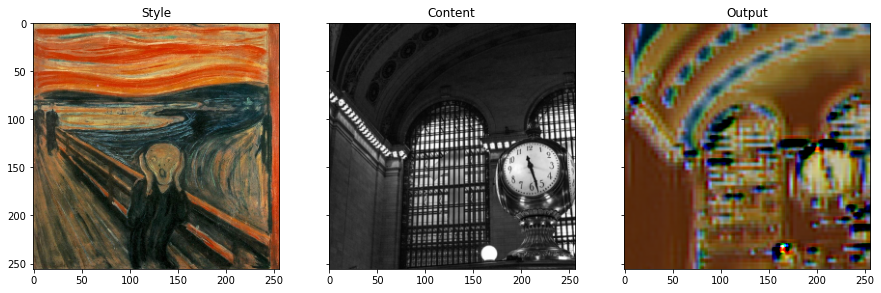

Mon Jan 23 01:56:52 2023 | Epoch 3: [40480/40504] | content: 0.001/0.001, style: 0.002/0.002, total: 0.003: 100%|██████████| 3/3 [3:33:07<00:00, 4262.66s/it]  


In [7]:
train()